In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

$\textbf{Аналитическое решение}: u = \frac{r^{2} (\sin{\theta})^{2}}{(9-8t)}$

In [2]:
def a_sol(r, theta, t):
    u = ((r**2)*((np.sin(theta))**2))/(9-8*t) 
    return u

$\textbf{Численное решение}$

Пользуемся неявной четырехточечной схемой. Применяем метод расщепления по направлениям и последующую прогонку

In [3]:
def forw_prop(a, b, c, d):
    N = a.shape[0]
    alpha = np.zeros(N)
    betta = np.zeros(N)
    alpha[0] = - a[0]/b[0]
    betta[0] = d[0]/b[0]
    for l in range(1, N):
        alpha[l] = - a[l]/(b[l]+c[l]*alpha[l-1])
        betta[l] = (d[l]-c[l]*betta[l-1])/(b[l]+c[l]*alpha[l-1])
        
    return alpha, betta

def back_prop(alpha, betta, uL):
    N = alpha.shape[0]
    u = np.zeros(N+1)
    u[-1] = uL
    for l in range(N-1, -1, -1):
        u[l] = alpha[l]*u[l+1]+betta[l]
        
    return u

In [4]:
def solve_sub(u, u_k, tau, h_r, h_th, t):
    Nr = u_k.shape[0]
    Nth = u_k.shape[1]
    
    u_sol = np.zeros((Nr, Nth))
    r = np.linspace(0, 1, Nr)
    theta = np.linspace(0, np.pi/2, Nth)

    for j in range(1, Nth-1):
        a = - (r[1:-1]+h_r/2)**2 * (u_k[2:, j]+u_k[1:-1, j]) \
            * tau / (2*r[1:-1]**2*h_r**2)
        c = - (r[1:-1]-h_r/2)**2 * (u_k[1:-1, j]+u_k[:-2, j]) \
            * tau / (2*r[1:-1]**2*h_r**2)
        b = 1 - a - c+2
        d = u[1:-1, j]+2*np.vectorize(a_sol)(r[1:-1], theta[j], t+tau)
        a = np.concatenate(([0], a), axis = 0)
        b = np.concatenate(([1], b), axis = 0)
        d = np.concatenate(([0], d), axis = 0)
        c = np.concatenate(([0], c), axis = 0)

        u_L = np.sin(theta[j])**2*(9-8*(tau+t))**(-1)
        
        alpha, betta = forw_prop(a, b, c, d)
        u_sol[:, j] = back_prop(alpha, betta, u_L)
    
    u_sol[:, -1] = r**2*(9-8*(t+tau))**(-1)
    #u_sol[-1, :] = np.sin(theta)**4*(14-12*(tau+t))**(-2)
    return u_sol

def solve_sys(u_sub, u_k, tau, h_r, h_th, t):
    Nr = u_k.shape[0]
    Nth = u_k.shape[1]
    
    u_sol = np.zeros((Nr, Nth))
    r = np.linspace(0, 1, Nr)
    theta = np.linspace(0, np.pi/2, Nth)
    
    for i in range(1, Nr-1):
        a = -np.sin(theta[1:-1]+h_th/2)*(u_k[i, 2:]+u_k[i, 1:-1]) \
            *tau / (2*r[i]**2*np.sin(theta[1:-1])*h_th**2)
        c = -np.sin(theta[1:-1]-h_th/2)*(u_k[i, 1:-1]+u_k[i, :-2]) \
            *tau / (2*r[i]**2*np.sin(theta[1:-1])*h_th**2)
        b = 1 - a - c + 2
        d = u_sub[i, 1:-1]+2*np.vectorize(a_sol)(r[i], theta[1:-1], t+tau)
        
        a = np.concatenate(([0], a), axis = 0)
        b = np.concatenate(([1], b), axis = 0)
        d = np.concatenate(([0], d), axis = 0)
        c = np.concatenate(([0], c), axis = 0)
        
        u_M = r[i]**2*(9-8*(t+tau))**(-1)
        
        alpha, betta = forw_prop(a, b, c, d)
        u_sol[i, :] = back_prop(alpha, betta, u_M)

    u_sol[-1, :] = np.sin(theta)**2 / ( (9-8*(t+tau)) )
    return u_sol

In [5]:
def one_step(u, u_k, tau, h_r, h_th, t):
    u_sub = solve_sub(u, u_k, tau, h_r, h_th, t)
    return solve_sys(u_sub, u_k, tau, h_r, h_th, t)

def solve(Nr, Nth, Nt):
    # start layer
    r = np.linspace(0, 1, Nr)
    theta = np.linspace(0, np.pi/2, Nth)
    sol = np.zeros((Nr, Nth))
    for j in range(Nth):
        sol[:, j] = r**2*(np.sin(theta[j])**2)/9
    EPS = 1e-2
    
    tau = 1/(Nt-1)
    h_r = 1/(Nr-1)
    h_th = np.pi/2/(Nth-1)
    exit = False
    for i in range(0, Nt-1):
        t = tau*i
        prev_sol = np.copy(sol)
        for k in range(1):
            new_sol = one_step(sol, prev_sol, tau, h_r, h_th, t)
            if np.max(np.abs((new_sol[1:-1,1:-1]-prev_sol[1:-1,1:-1])/new_sol[1:-1, 1:-1])) < EPS:
                #print(k)
                sol = np.copy(new_sol)
                break
            prev_sol = np.copy(new_sol)
            if k == 7:
                print('progonka not converged')
                print(t)
            sol = np.copy(new_sol)
        if(exit):
            break
                
    return sol

Аналитическое решение

In [6]:
Nr = 11
Nthet = 11

r = np.linspace(0, 1, Nr)
thet = np.linspace(0, np.pi/2, Nthet)

rv, thetv = np.meshgrid(r, thet, sparse=False, indexing='ij')

func = lambda x, y : a_sol(x, y, 1)

anal = np.vectorize(func)(rv, thetv)

df = pd.DataFrame(anal, columns = thet, index=r, dtype = float) 
df.T

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.157080,0.0,0.000245,0.000979,0.002202,0.003915,0.006118,0.008810,0.011991,0.015662,0.019822,0.024472
0.314159,0.0,0.000955,0.003820,0.008594,0.015279,0.023873,0.034377,0.046791,0.061115,0.077348,0.095492
0.471239,0.0,0.002061,0.008244,0.018550,0.032977,0.051527,0.074199,0.100993,0.131909,0.166947,0.206107
0.628319,0.0,0.003455,0.013820,0.031094,0.055279,0.086373,0.124377,0.169291,0.221115,0.279848,0.345492
0.785398,0.0,0.005000,0.020000,0.045000,0.080000,0.125000,0.180000,0.245000,0.320000,0.405000,0.500000
0.942478,0.0,0.006545,0.026180,0.058906,0.104721,0.163627,0.235623,0.320709,0.418885,0.530152,0.654508
1.099557,0.0,0.007939,0.031756,0.071450,0.127023,0.198473,0.285801,0.389007,0.508091,0.643053,0.793893
1.256637,0.0,0.009045,0.036180,0.081406,0.144721,0.226127,0.325623,0.443209,0.578885,0.732652,0.904508
1.413717,0.0,0.009755,0.039021,0.087798,0.156085,0.243882,0.351190,0.478009,0.624338,0.790178,0.975528


Численное решение

In [7]:
Nr = 21
Nthet = 21
Nt = 101
comp = solve(Nr, Nthet, Nt)

In [8]:
#r = np.linspace(0, 1, Nr)
#thet = np.linspace(0, np.pi/2, Nthet)
#rv, thetv = np.meshgrid(r, thet, sparse=False, indexing='ij')

r = np.linspace(0, 1, 11)
thet = np.linspace(0, np.pi/2, 11)
rv, thetv = np.meshgrid(r, thet, sparse=False, indexing='ij')
df = pd.DataFrame(comp[::(Nr-1)//10, ::(Nthet-1)//10], columns = thet, index=r, dtype = float)
df.T

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.157080,0.0,0.000250,0.000999,0.002248,0.003997,0.006245,0.008993,0.012241,0.015988,0.020235,0.024472
0.314159,0.0,0.000971,0.003885,0.008740,0.015538,0.024278,0.034960,0.047584,0.062151,0.078666,0.095492
0.471239,0.0,0.002090,0.008359,0.018806,0.033432,0.052237,0.075221,0.102384,0.133726,0.169282,0.206107
0.628319,0.0,0.003493,0.013963,0.031414,0.055846,0.087258,0.125651,0.171024,0.223382,0.282798,0.345492
0.785398,0.0,0.005038,0.020136,0.045299,0.080528,0.125822,0.181181,0.246607,0.322107,0.407773,0.500000
0.942478,0.0,0.006573,0.026268,0.059092,0.105047,0.164131,0.236345,0.321689,0.420172,0.531860,0.654508
1.099557,0.0,0.007951,0.031767,0.071462,0.127034,0.198483,0.285811,0.389016,0.508098,0.643057,0.793893
1.256637,0.0,0.009039,0.036112,0.081232,0.144402,0.225619,0.324884,0.442196,0.577539,0.730830,0.904508
1.413717,0.0,0.009738,0.038903,0.087511,0.155562,0.243057,0.349995,0.476371,0.622160,0.787222,0.975528


Модуль разности аналитического и численного решений

In [9]:
r = np.linspace(0, 1, 11)
thet = np.linspace(0, np.pi/2, 11)
rv, thetv = np.meshgrid(r, thet, sparse=False, indexing='ij')
df = pd.DataFrame(np.abs(comp[::(Nr-1)//10, ::(Nthet-1)//10] - anal), columns = thet, index=r, dtype = float)
df.T

,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0
0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
0.157080,0.0,0.000005,0.000020,0.000046,0.000082,0.000127,0.000183,0.000250,0.000326,0.000413,0.0
0.314159,0.0,0.000016,0.000065,0.000146,0.000259,0.000405,0.000583,0.000793,0.001036,0.001318,0.0
0.471239,0.0,0.000029,0.000114,0.000256,0.000455,0.000710,0.001022,0.001391,0.001818,0.002335,0.0
0.628319,0.0,0.000038,0.000144,0.000320,0.000567,0.000885,0.001274,0.001733,0.002268,0.002949,0.0
0.785398,0.0,0.000038,0.000136,0.000299,0.000528,0.000822,0.001181,0.001607,0.002107,0.002773,0.0
0.942478,0.0,0.000028,0.000087,0.000187,0.000325,0.000504,0.000722,0.000980,0.001287,0.001708,0.0
1.099557,0.0,0.000012,0.000012,0.000011,0.000011,0.000010,0.000010,0.000009,0.000007,0.000004,0.0
1.256637,0.0,0.000006,0.000069,0.000173,0.000320,0.000508,0.000739,0.001013,0.001347,0.001822,0.0
1.413717,0.0,0.000018,0.000119,0.000287,0.000522,0.000825,0.001195,0.001637,0.002178,0.002956,0.0


Погрешность решения

In [10]:
print('Погрешность решения:')
print(np.max(np.abs(comp[::(Nr-1)//10, ::(Nthet-1)//10] - anal)))

Погрешность решения:
0.002956089836526954


Порядок аппроксимации

In [16]:
M = 4
err_r = np.zeros(M)

A = 10
B = 10

for i in range(1, M+1):
    Nr = A*(i)+1
    Nthet = A*(i)+1
    Nt = B*(i**2)+1
    comp = solve(Nr, Nthet, Nt)
    err_r[i-1] = np.max(np.abs(comp[::(Nr-1)//10, ::(Nthet-1)//10] - anal))

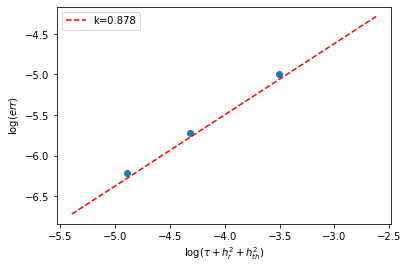

In [17]:
from scipy.optimize import curve_fit

def f(x, a, b):
    return a*x+b

a = np.arange(1, M+1)
step = 1/(B*(a**2))+1/(A*a)**2+1/(A*a)**2

plt.xlabel(r'$\log(\tau+h_r^2+h_{th}^2)$')
plt.ylabel('$\log(err)$')

popt, pcov = curve_fit(f, np.log(step)[1:], np.log(err_r)[1:])

mn = np.min(step)
mx = np.max(step)

plt.plot([np.log(mn)-0.5, np.log(mx)-0.5], 
         [popt[0]*np.log(mn)-0.5+popt[1], popt[0]*np.log(mx)-0.5+popt[1]],
         color='r', linestyle='--', label='k={:.3}'.format(popt[0]))
plt.scatter(np.log(step)[1:], np.log(err_r)[1:])
plt.legend()
plt.show()

In [18]:
for i in range(1, M):
    Nr = A*(i+1)+1
    Nthet = A*(i+1)+1
    Nt = B*((i+1)**2)+1
    print('Nr:', Nr, 'Nthet:', Nthet, 'Nt:', Nt)
    print('error:', err_r[i])

Nr: 21 Nthet: 21 Nt: 41
error: 0.0067396755472123315
Nr: 31 Nthet: 31 Nt: 91
error: 0.003273401448219304
Nr: 41 Nthet: 41 Nt: 161
error: 0.0019964714148128504
